In [390]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [391]:
path = kagglehub.dataset_download("clkmuhammed/autoscout24-car-listings-dataset")
df = pd.read_csv(
    os.path.join(path,"autoscout24_dataset_20251108.csv"),
    encoding='utf-8',
    sep=',',
    engine='python')

In [392]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118382 entries, 0 to 118381
Data columns (total 75 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id                                    118382 non-null  object 
 1   description                           113990 non-null  object 
 2   ratings_average                       76428 non-null   object 
 3   ratings_count                         76428 non-null   float64
 4   ratings_recommend_percentage          76428 non-null   float64
 5   price_currency                        118382 non-null  object 
 6   price                                 118382 non-null  float64
 7   price_tax_deductible                  118382 non-null  bool   
 8   price_negotiable                      118382 non-null  bool   
 9   price_net                             34016 non-null   float64
 10  price_vat_rate                        30379 non-null   float64
 11  

In [393]:
#usuwanie kolumn nie związanych z samochodami na sprzedaż

unrelated_cols = ['zip','city','street','latitude','longitude','seller_is_dealer','seller_company_name','seller_type','ratings_average','ratings_count','ratings_recommend_percentage']

df.drop(columns=unrelated_cols,inplace=True)

# kolumny o wyposażeniu na razie usuwam bo będą ciężkie do zencodowania (listy featurów)
# potem powyciągam elementy list zrobię ich rozkłady i zachowam te elementy z dużą korelacją jako osobne kolumny albo coś innego z nimi zrobimy

equipment_cols = ['equipment_comfort','equipment_entertainment','equipment_extra','equipment_safety']
df.drop(columns=equipment_cols,inplace=True)



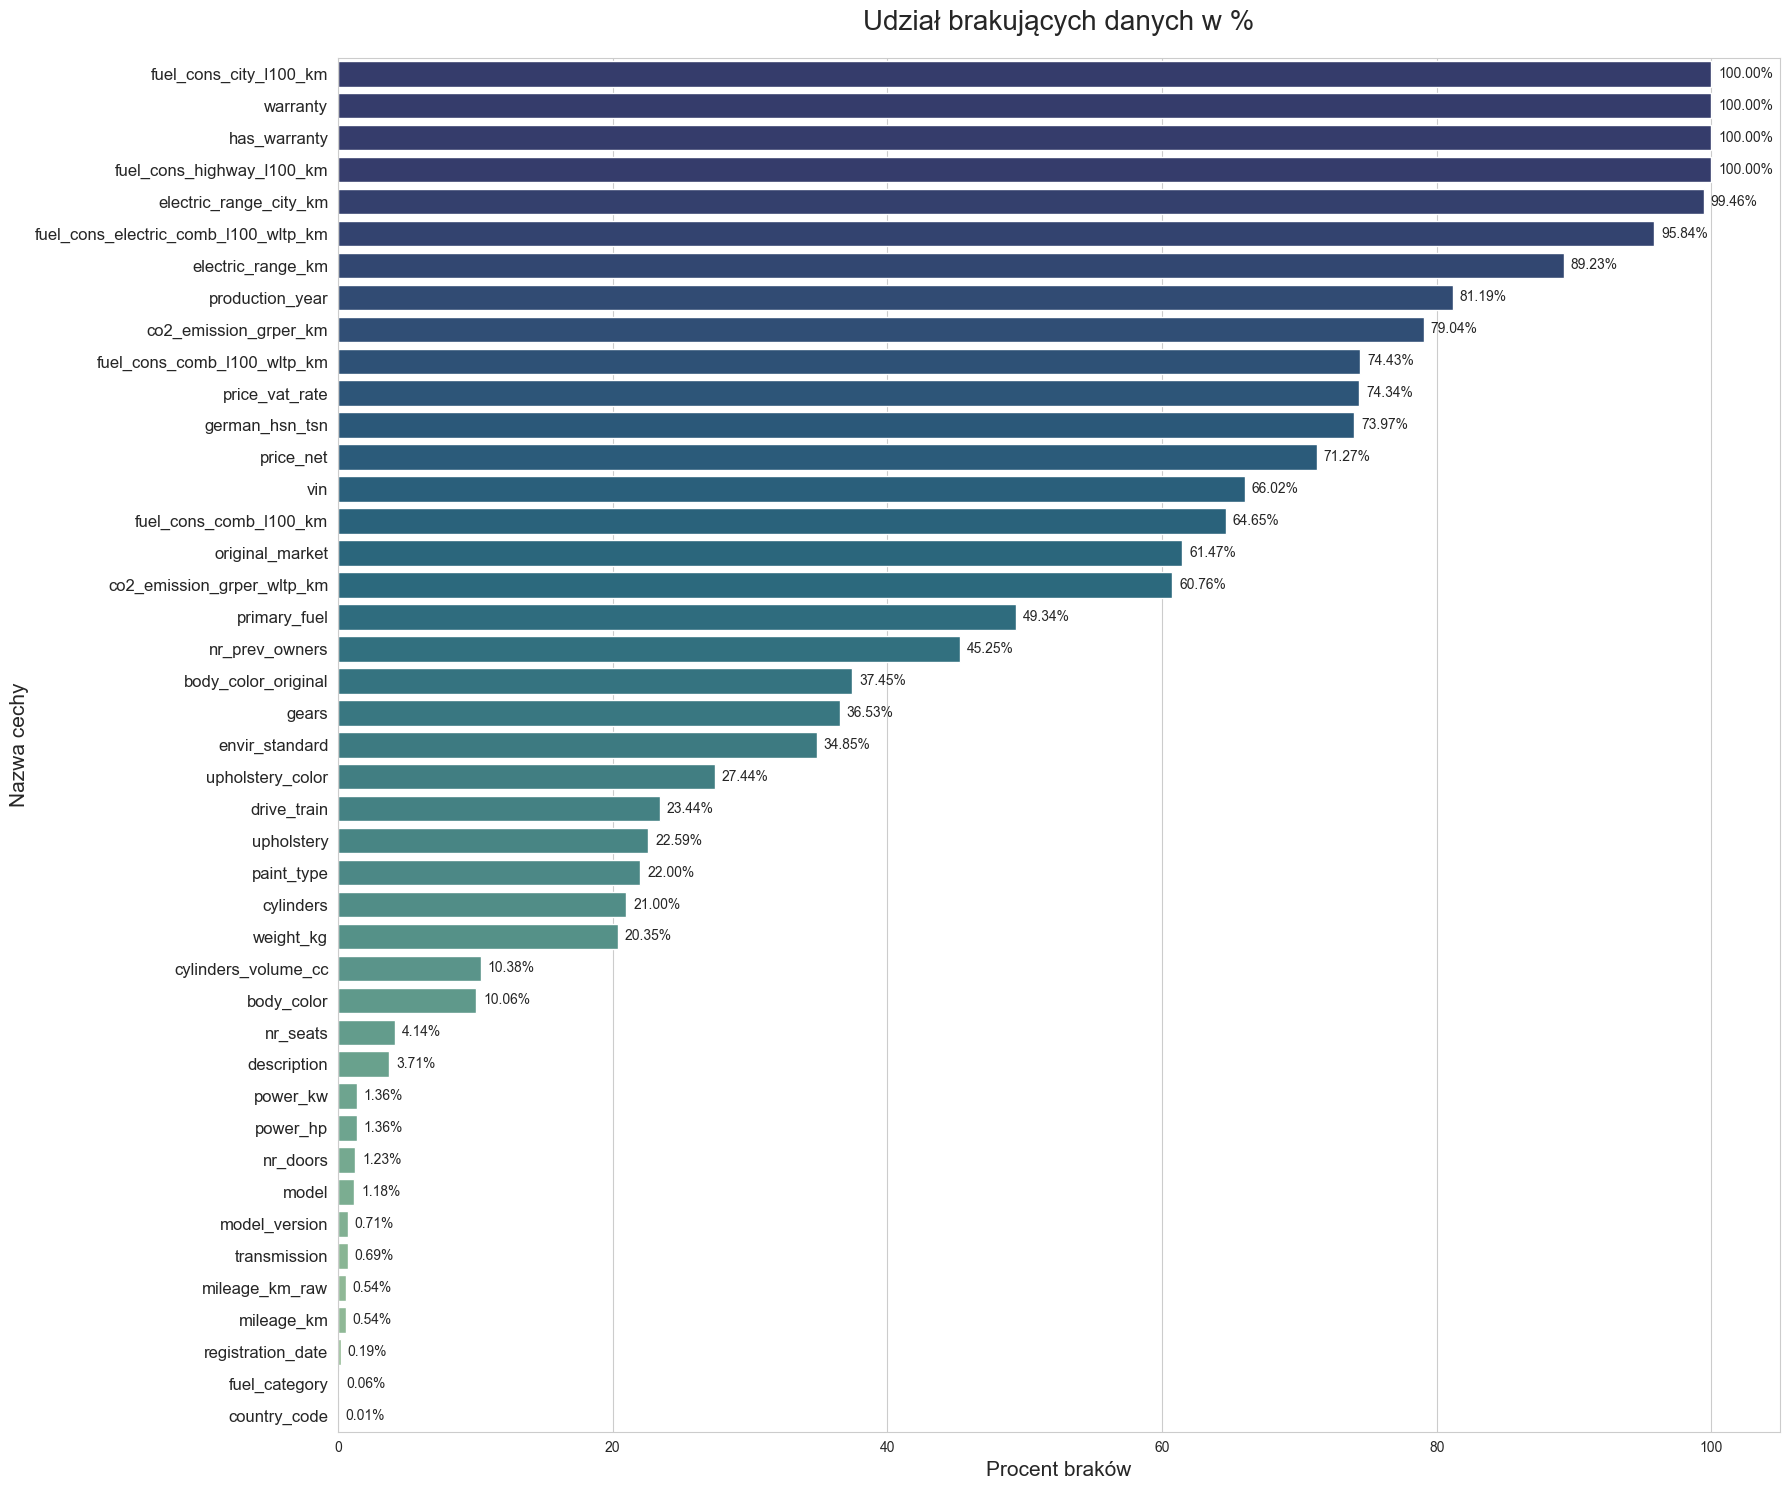

In [394]:
#puste kolumny

missing_data = (df.isnull().sum()/len(df)) *100
missing_data = missing_data[missing_data>0].sort_values(ascending = False).reset_index()
missing_data.columns = ["Cecha","Procent"]

plt.figure(figsize=(18,15))
sns.set_style("whitegrid")
plt.title('Udział brakujących danych w %',fontsize= 20,pad=20)
ax = sns.barplot(
    x='Procent',
    y='Cecha',
    data = missing_data,
    palette = sns.color_palette("crest",38),
    hue = 'Procent',
    legend = False
)

for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%', padding=5,fontsize= 10)
    
plt.yticks(fontsize=12)
plt.xlabel('Procent braków',fontsize= 15)
plt.ylabel('Nazwa cechy',fontsize = 15)
plt.tight_layout()
plt.show()

# do modyfikacji w zależności od ostatecznej potrzeby (jeszcze idk jakie będzią ostatecznie)
# w %
col_cutoff_treshold = 48
col_trim_treshhold = 2

#usuwanie brakujących kolumn i rzędów
cols_to_drop  = missing_data[missing_data['Procent'] > col_cutoff_treshold]['Cecha'].tolist()
cols_to_trim = missing_data[missing_data['Procent'] < col_trim_treshhold]['Cecha'].tolist()

df.drop(columns=cols_to_drop,inplace=True)
df.dropna(subset=cols_to_trim,inplace=True)

In [395]:
#nwm czy jestem ślepa ale jednak nadal trzeba te casty na floaty/inty zrobić
df['weight_kg'] = df['weight_kg'].str.replace(' kg', '', regex=False)
df['weight_kg'] = df['weight_kg'].str.replace(',', '', regex=False).astype('float64')

# to te same wartości co w kolumnie mileage_km_raw
del df['mileage_km']
#tutaj też datę rejestracji przekształcam na wiek
df['registration_date'] = df['registration_date'].str.extract('(\d{4})').astype('float64')
df['car_age'] = 2026 - df['registration_date']
del df['registration_date']

#wartości unikalne
for column in df.columns:
    if df[column].dtype == 'object':
        print(f"Column {column} has {df[column].nunique()}")
    
#tutaj będzie taki ładny wykres jak powyżej :) 

#kolumny kategoryczne które mają ponad 90% wartości unikalnych usuniemy
unique_treshold = 0.90

#usuwanie kolumn o dużej ilości unikalnych wartości
cols_to_drop  = [col for col in df.select_dtypes(include='object').columns if df[col].nunique()/len(df) > unique_treshold or df[col].nunique() == 1 ]

# te kolumny również mają imo za dużo unique values, jeszcze się zastawnowię jak ładniej je w pipeline usuwać
df.drop(columns=['model','model_version','body_color_original'], inplace=True)
df.drop(columns=cols_to_drop,inplace=True)

Column id has 112227
Column description has 102275
Column price_currency has 1
Column make has 25
Column model has 620
Column model_version has 80796
Column vehicle_type has 1
Column body_type has 9
Column body_color has 14
Column paint_type has 2
Column body_color_original has 10788
Column upholstery has 6
Column upholstery_color has 11
Column transmission has 3
Column drive_train has 3
Column fuel_category has 9
Column envir_standard has 11
Column offer_type has 3
Column country_code has 8


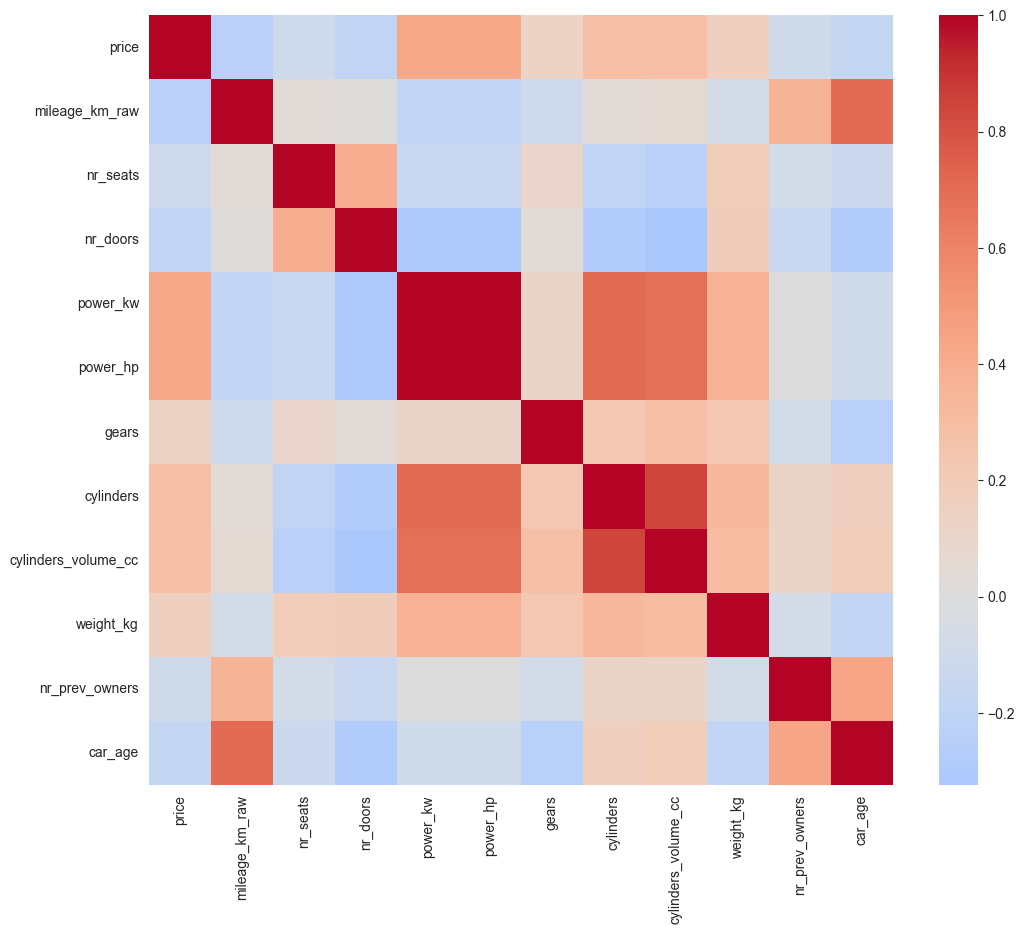

In [396]:
target_col = 'price'

# podział kolumn ze względu na typ 
numeric_cols = df.select_dtypes(include=["float","int"]).columns.tolist()

bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

# zmienię ten wykres jeszcze potem 
corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.show()

#dopiero w tym miejscu żeby na wykresie było widać
numeric_cols.remove(target_col)

In [397]:
def fill_cols(data,numeric_cols,categorical_cols,stats):
    for col in numeric_cols:
        if col == 'gears' or col == 'nr_prev_owners':
            data[col] = data[col].fillna(0)
        else :
            data[col] = data[col].fillna(stats[col])
    for col,_ in categorical_cols:
        data[col] = data[col].fillna(stats[col])
    return data
            

def preprocess(data,numeric_cols,categorical_cols,scaler,stats):
    data = fill_cols(data,numeric_cols,categorical_cols,stats)
    data[numeric_cols] = scaler.transform(data[numeric_cols])
    for col,vals in categorical_cols:
        data[col] = pd.Categorical(data[col], categories=vals)
    data = pd.get_dummies(data, drop_first=True)
    return data


In [398]:
# sorki jednak robię train/test split bo potrzebuje to zrobić by przetestować preprocessing, ale możesz to pozmieniać żeby był też validation set
# możesz też ładniej ogarnąć seedowanie w projekcie ogólnie

X, y = df.drop(target_col, axis=1), df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

categorical_cols_with_vals = [ (col,[val for val in X_train[col].unique().tolist() if pd.notna(val)] ) for col in categorical_cols]

# to robię by uniknąć data leakage (pewnie poprawię potem by ładniej wyglądało)
stats = {}
for col in numeric_cols:
    stats[col] = X_train[col].median()
for col in categorical_cols:
    stats[col] = X_train[col].mode()[0]

# tutaj gotowe dane do karmienia modelu 
X_train_preprocessed = preprocess(X_train,numeric_cols,categorical_cols_with_vals,scaler,stats)
X_test_preprocessed = preprocess(X_test,numeric_cols,categorical_cols_with_vals,scaler,stats)
